# Schelling Segregation Model

## Implementation

 Below, we will import the model class, instantiate it, run it, and plot the time series of the number of happy agents.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from model1 import Schelling

Now we instantiate a model instance: a 10x10 grid, with an 80% chance of an agent being placed in each cell, approximately 20% of agents set as minorities, and agents wanting at least 30% similar neighbors.

In [27]:
model = Schelling(30, 30, 0.8, 0.2, 0.3)

This is model 1


We want to run the model until all the agents are happy with where they are. However, there's no guarentee that a given model instantiation will *ever* settle down. So let's run it for either 100 steps or until it stops on its own, whichever comes first:

In [28]:
while model.running and model.schedule.steps < 200:
    model.step()

print(model.schedule.steps) # Show how many steps have actually run

86


In [29]:
print(model.schedule.get_agent_count())

700


The model has a DataCollector object, which checks and stores how many agents are happy at the end of each step. It can also generate a pandas DataFrame of the data it has collected:

In [30]:
model_out = model.datacollector.get_model_vars_dataframe()

In [31]:
model_out.sort_values('happy', ascending=False)

,happy,total_satisfaction_index,blue_satisfaction_index,red_satisfaction_index
86,700,0.998571,0.993243,1.000000
57,699,0.998571,0.993243,1.000000
64,699,0.998571,0.993243,1.000000
63,699,0.998571,0.993243,1.000000
62,699,0.998571,0.993243,1.000000
...,...,...,...,...
4,648,0.918571,0.621622,0.998188
3,643,0.894286,0.547297,0.987319
2,626,0.838571,0.317568,0.978261
1,587,0.000000,0.000000,0.000000


Finally, we can plot the 'happy' series:

<Axes: >

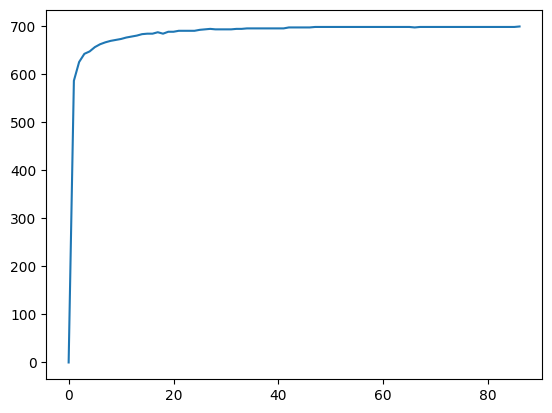

In [32]:
model_out.happy.plot()

For testing purposes, here is a table giving each agent's x and y values at each step.

In [33]:
x_positions = model.datacollector.get_agent_vars_dataframe()

In [34]:
x_positions.head()

x  y
Step AgentID      
0    (0, 0)   0  0
     (0, 4)   0  4
     (0, 5)   0  5
     (0, 6)   0  6
     (0, 7)   0  7

# Effect of Homophily on segregation

Now, we can do a parameter sweep to see how segregation changes with homophily.

First, we create a function which takes a model instance and returns what fraction of agents are segregated -- that is, have no neighbors of the opposite type.

In [9]:
from mesa.batchrunner import BatchRunner

In [10]:
def get_segregation(model):
    '''
    Find the % of agents that only have neighbors of their same type.
    '''
    segregated_agents = 0
    for agent in model.schedule.agents:
        segregated = True
        for neighbor in model.grid.neighbor_iter(agent.pos):
            if neighbor.type != agent.type:
                segregated = False
                break
        if segregated:
            segregated_agents += 1
    return segregated_agents / model.schedule.get_agent_count()

Now, we set up the batch run, with a dictionary of fixed and changing parameters. Let's hold everything fixed except for Homophily.

In [11]:
parameters = {"height": 10, "width": 10, "density": 0.8, "minority_pc": 0.2, 
              "homophily": range(1,9)}

In [12]:
model_reporters = {"Segregated_Agents": get_segregation}

In [13]:
param_sweep = BatchRunner(Schelling, parameters, iterations=10,
                          max_steps=200, model_reporters=model_reporters)

In [14]:
param_sweep.run_all()

everyone is happy
everyone is happy
everyone is happy
everyone is happy
everyone is happy
everyone is happy
everyone is happy
everyone is happy
everyone is happy
everyone is happy
everyone is happy
everyone is happy
everyone is happy
everyone is happy
everyone is happy
everyone is happy
everyone is happy
everyone is happy
everyone is happy
everyone is happy
everyone is happy
everyone is happy
everyone is happy
everyone is happy
everyone is happy


In [15]:
df = param_sweep.get_model_vars_dataframe()

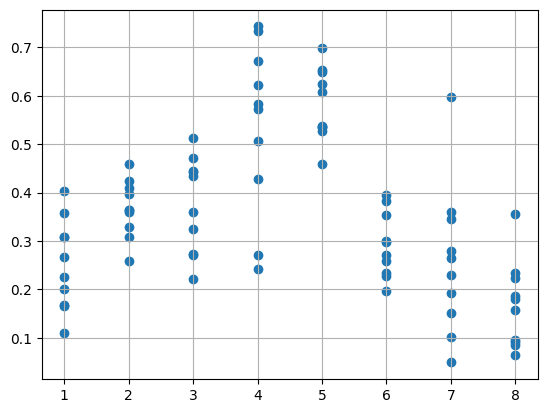

In [16]:
plt.scatter(df.homophily, df.Segregated_Agents)
plt.grid(True)